# Complex systems simulation

Kevin: This is the closest algorithm I can formulate when analyzing the papers. Maybe it'll be useful. Please tell me or correct it if you think something is missing or wrong here. I find that it resembles the BTW algorithm somewhat, so we'll probably find some SOC by that resemblance alone. I added both the dynamics synapses and leak parts. I think they can be ignored quite easily if we don't want those elements though.

## (Leaky) integrate and fire algorithm with LHG dynamics

1. Initialize network with potentials $V_i$ for the node values and Synaptic strengths $J_{ij}$ for the link values with $J_{ij} \neq J_{ji}$

2. Initialize parameters:
    - $V^{ext}$: External input into membrane potential
    - $u$: Transmitter resource usage / saturation constant of synaptic strength
    - $V^{th}$: Membrane potential threshold
    - $\alpha$: Maximum connection strength parameter (Dynamic synapses)
    - $\tau_{J}$: Synaptic strength relaxation time (Dynamic synapses)
    - $\tau_l$: Leak time constant (leak term)
    - $C$: Compensatory synaptic current (leak term)

3. Drive step:
    - $V_j \gets V_j - \frac{V_j}{\tau_l} + C$ for all neurons $j$
    - Randomly select a neuron i
    - $V_i \gets V_i + V^{ext}$ (Forward Euler)

4. Relaxation step:
    - For all neighbors $j$ of $i$, if $V_i > V^{th}$:
        - $V_j \gets V_j + \frac{u J_{ji}}{N_i}$
    
    - $V_i \gets V_i - V^{th}$
    - Repeat for all cases of $j$ where $V_j > V^{th}$
    
5. Update synaptic strength:
    - $J_{ij} \gets J_{ij} + \frac{1}{\tau_l}\left( \frac{\alpha}{u} - J_{ij} \right) - u J_{ij}$ for all spiked synapses
    - $J_{ij} \gets J_{ij} + \frac{1}{\tau_l}\left( \frac{\alpha}{u} - J_{ij} \right)$ for all unused synapses

6. Go back to step 3 or terminate algorithm

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle

import integrate_and_fire as int_fire

In [2]:
# Function definitions
def remove_links(matrix, n):
    "Removes n links"
    r = list(zip(np.where(A != 0)[0], np.where(matrix != 0)[1]))
    k = random.sample(r, n)
    s = np.array(k)
    matrix[s[:,0], s[:,1]] = 0
    return matrix

# Function for the simulation of a single process (using multiprocessing)
def static_process_simulate(res_dict,size,net_type,J,init_steps=10000,steps=1000000):
    network = int_fire.create_if_network(size,net_type=net_type)

    model = int_fire.simple_integrate_and_fire_model(network,J=J)
    model.simulate(init_steps)
    model.reset_avalanche_stats()
    model.simulate(steps)
    
    res_dict[size] = model
    
# Calculate avalanche size pdf from avalanche time series
def avalanche_size_pdf(avalanches):
    pdf = np.bincount(avalanches) / avalanches.size
        
    nonzeros = (pdf != 0)
    indices = np.arange(nonzeros.size)[nonzeros]
    
    return indices,pdf[nonzeros]

# Test static integrate and fire model

## Sub critical connection strength

In [6]:
J = 3.5

sub_models = {}
for n in [25,50,75,100]:
    network = int_fire.create_if_network(n,net_type="full")

    model = int_fire.simple_integrate_and_fire_model(network,J=J)
    model.simulate(10000)
    model.reset_avalanche_stats()
    model.simulate(1000000)
    
    sub_models[n] = model

100%|██████████| 1000000/1000000 [02:46<00:00, 6015.62it/s]


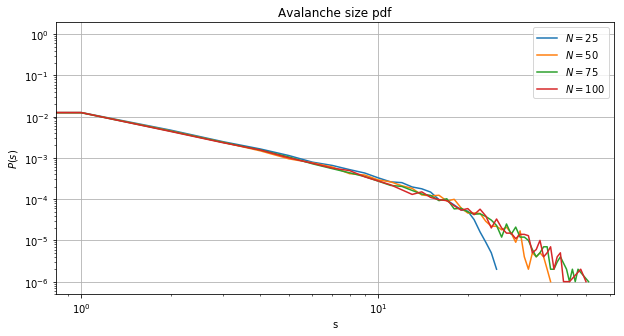

In [7]:
plt.figure(figsize=(10,5))
plt.title(r"Avalanche size pdf")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"s")

for n in [25,50,75,100]:
    indices,pdf = sub_models[n].avalanche_size_pdf()
    plt.plot(indices,pdf,label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

## Critical connection strength

In [8]:
J = 4.71

crit_models = {}
for n in [25,50,75,100]:
    network = int_fire.create_if_network(n,net_type="full")

    model = int_fire.simple_integrate_and_fire_model(network,J=J)
    model.simulate(10000)
    model.reset_avalanche_stats()
    model.simulate(1000000)
    
    crit_models[n] = model

100%|██████████| 1000000/1000000 [11:29<00:00, 1449.79it/s]


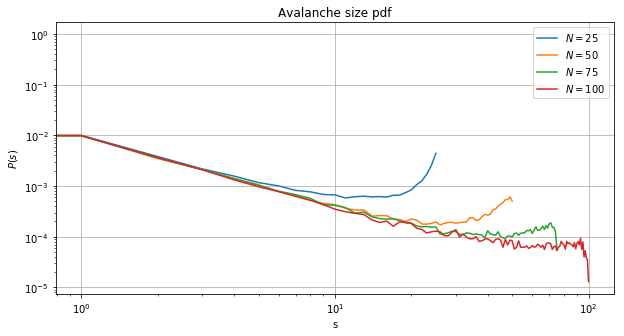

In [9]:
plt.figure(figsize=(10,5))
plt.title(r"Avalanche size pdf")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"s")

for n in [25,50,75,100]:
    indices,pdf = crit_models[n].avalanche_size_pdf()
    plt.plot(indices,pdf,label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

## Super critical connection strength

In [9]:
J = 4.9

manager = mp.Manager()
res_dict = manager.dict()

processes = [mp.Process(target = static_process_simulate,
                        args=(res_dict,n,"full",J)) for n in [25,50,75,100]]

for p in processes:
    p.start()
    
for p in processes:
    p.join()

100%|██████████| 1000000/1000000 [1:08:31<00:00, 243.22it/s]


In [13]:
# Store models outside of manager dict
super_models = {}
for n in [25,50,75,100]:
    super_models[n] = res_dict[n]

In [41]:
# Save avalanche size arrays for later use
#for n in [25,50,75,100]:
#    np.save("../data/static_super_full_%i" % (n),super_models[n].avalanche_size)

### Data collapse

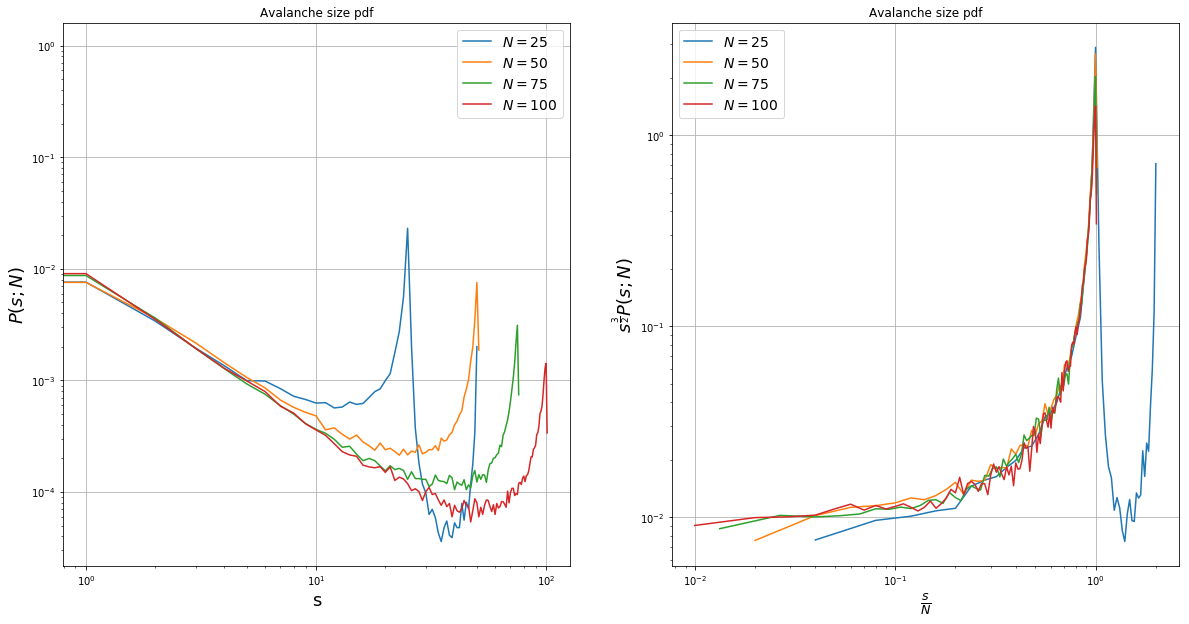

In [10]:
tau = 3/2

#avalanches = {}
#for n in [25,50,75,100]:
#    avalanches[n] = np.load("../data/static_super_full_%i.npy" % (n))

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title(r"Avalanche size pdf")
plt.ylabel(r"$P(s;N)$",fontsize=18)
plt.xlabel(r"s",fontsize=18)

for n in [25,50,75,100]:
    s,pdf = super_models[n].avalanche_size_pdf()
    #s,pdf = avalanche_size_pdf(avalanches[n])
    
    plt.plot(s,pdf,label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.title(r"Avalanche size pdf")
plt.ylabel(r"$s^\frac{3}{2} P(s;N)$",fontsize=18)
plt.xlabel(r"$\frac{s}{N}$",fontsize=18)

for n in [25,50,75,100]:
    s,pdf = super_models[n].avalanche_size_pdf()
    #s,pdf = avalanche_size_pdf(avalanches[n])
    
    plt.plot(s[1:]/n,(s[1:]**tau)*pdf[1:],label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(fontsize=14)

plt.show()

# Barabasi-Albert static

In [2]:
J = 4.9

static_super_ba = {}
for n in [25,50,75,100]:
    network = int_fire.create_if_network(n,net_type="ba")

    model = int_fire.simple_integrate_and_fire_model(network,J=J)
    model.simulate(10000)
    model.reset_avalanche_stats()
    model.simulate(1000000)
    
    static_super_ba[n] = model

100%|██████████| 1000000/1000000 [26:46<00:00, 622.33it/s] 


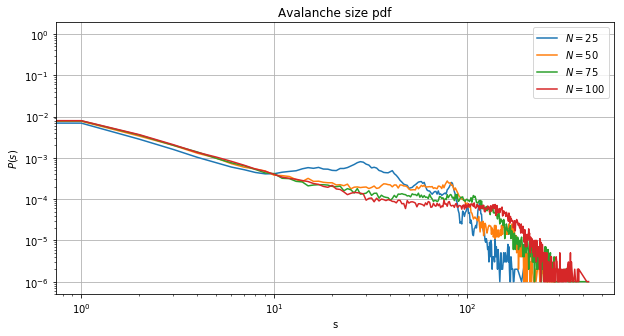

In [3]:
plt.figure(figsize=(10,5))
plt.title(r"Avalanche size pdf")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"s")

for n in [25,50,75,100]:
    indices,pdf = static_super_ba[n].avalanche_size_pdf()
    
    
    
    plt.plot(indices,pdf,label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

## Test LHG model

In [37]:
LHG_models = {}
for net in ["random","ba","ws"]:
    LHG_models[net] = {}
    for n in [50,100,200]:
        network = int_fire.create_if_network(n,net_type=net)
        model = int_fire.LHG_integrate_and_fire_model(network,a=0.9,p_inh=0.2)
        model.simulate(10000)
        model.reset_avalanche_stats()
        model.simulate(1000000)
        
        LHG_models[net][n] = model

100%|██████████| 1000000/1000000 [14:56<00:00, 1115.46it/s]


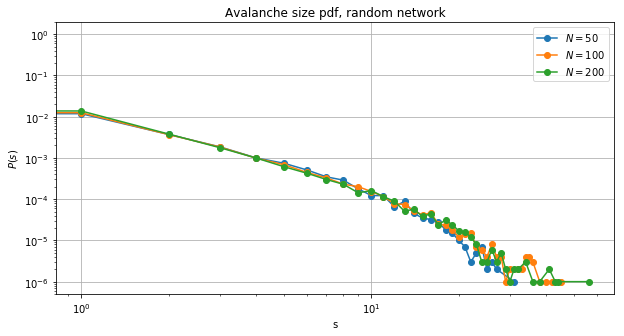

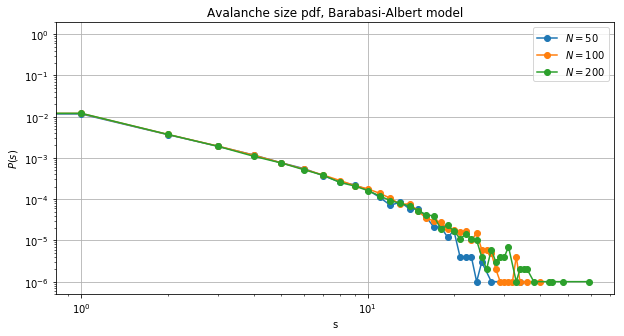

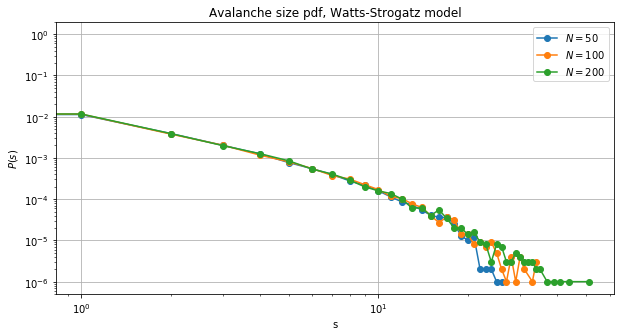

In [42]:
plt.figure(figsize=(10,5))
plt.title(r"Avalanche size pdf, random network")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"s")

for n in [50,100,200]:
    indices,pdf = LHG_models["random"][n].avalanche_size_pdf()
    plt.plot(indices,pdf,"o-",label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title(r"Avalanche size pdf, Barabasi-Albert model")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"s")

for n in [50,100,200]:
    indices,pdf = LHG_models["ba"][n].avalanche_size_pdf()
    plt.plot(indices,pdf,"o-",label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title(r"Avalanche size pdf, Watts-Strogatz model")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"s")

for n in [50,100,200]:
    indices,pdf = LHG_models["ws"][n].avalanche_size_pdf()
    plt.plot(indices,pdf,"o-",label=r'$N = %i$' % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

# Aging network analysis

## Find J in critical regime

In [56]:
J = 4.9

aging_manager = mp.Manager()
aging_dict = aging_manager.dict()

processes = [mp.Process(target = static_process_simulate,
                        args=(aging_dict,n,"aging",J)) for n in [50,100,200]]

for p in processes:
    p.start()
    
for p in processes:
    p.join()

# Store models outside of manager dict
age_models = {}
for n in [50,100,200]:
    age_models[n] = aging_dict[n]

100%|██████████| 1000000/1000000 [43:31<00:00, 382.94it/s]


In [79]:
# Save avalanche size arrays for later use
#for n in [50,100,200]:
#    np.save("../data/static_super_aging_%i" % (n),age_models[n].avalanche_size)

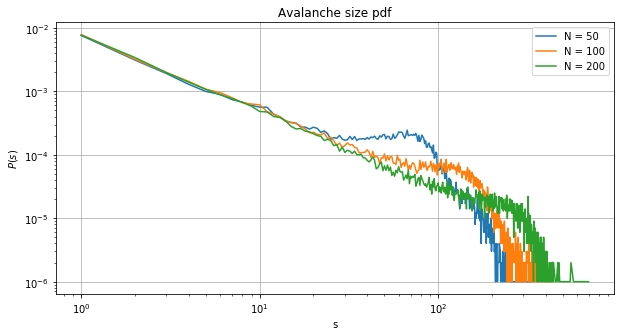

In [57]:
plt.figure(figsize=(10,5))
plt.title(r"Avalanche size pdf")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"s")

for n in [50,100,200]:
    indices,pdf = age_models[n].avalanche_size_pdf()
    plt.plot(indices[1:],pdf[1:],"-",label="N = %i" % n)

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

# Robustness